import os
import gdown
from zipfile import ZipFile
os.makedirs("/media/gamal/Passport/celeba")

url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
output = "/media/gamal/Passport/celeba/data.zip"
gdown.download(url, output, quiet=True)

with ZipFile("/media/gamal/Passport/celeba/data.zip", "r") as zipobj:
    zipobj.extractall("/media/gamal/Passport/celebaExt")


In [1]:
import pandas as pd

df_celeb = pd.read_csv('/media/gamal/Passport/celebaExt/list_attr_celeba.csv')
df_celeb.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [2]:
from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()

2023-09-26 11:26:18.599385: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-26 11:26:18.654753: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


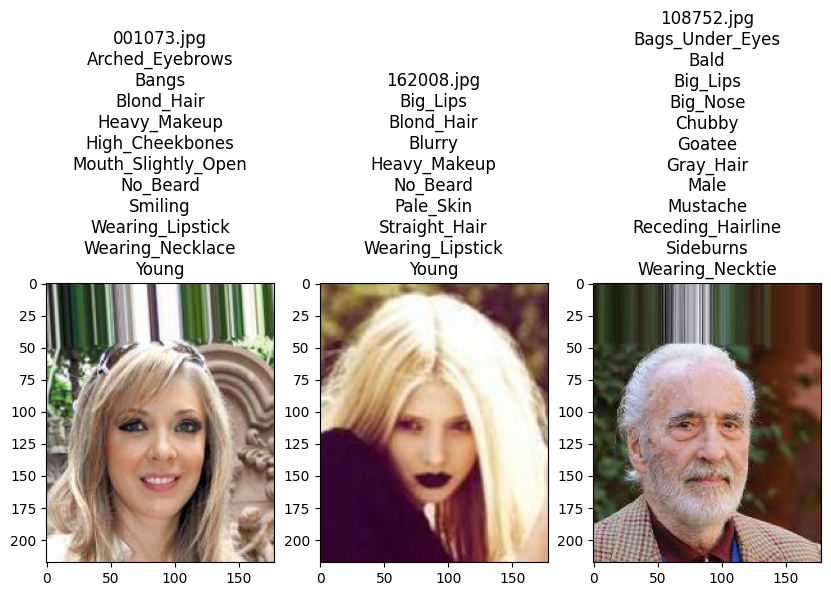

In [3]:
import matplotlib.pyplot as plt
import random
import skimage

def show_sample_image(nb=3, df=df_celeb, verbose=True):
    f, ax = plt.subplots(1, nb, figsize=(10,5))
    for i in range(nb):
        idx = random.randint(0, df.shape[0]-1)
        img_id = df.loc[idx].image_id
        img_uri = '/media/gamal/Passport/celebaExt/img_align_celeba/' + img_id
        img = skimage.io.imread(img_uri)  
        if verbose:
            label = img_id
            for col in df.columns:
                if df.loc[idx][col]==1:
                    label = label + '\n' + col  
            if nb > 1:
                ax[i].imshow(img)
                ax[i].set_title(label)
            else:
                ax.imshow(img) 
                ax.set_title(label)
        
    return img, list(df.loc[idx][1:df.shape[1]])
  
sample_img, sample_img_meta = show_sample_image()

In [4]:
import numpy as np
from keras.utils import Sequence

class CustomCelebrityFaceGenerator(Sequence):
    # initialize the custom generator
    def __init__(self, df, batch_size, target_height, target_width, conditioning_dim=0):
        self.df = df
        self.batch_size = batch_size
        self.target_height = target_height
        self.target_width = target_width
        self.conditioning_dim = conditioning_dim
        
    # shuffle the data after each epoch
    def on_epoch_end(self):
        self.df = self.df.sample(frac=1)
    
    # select a batch as tensor
    def __getitem__(self, index):
        cur_files = self.df.iloc[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__data_generation(cur_files)
        return X, y
    
    # 
    def __data_generation(self, cur_files):
        # initialize empty tensors to store the images   
        X = np.empty(shape=(self.batch_size, self.target_height, self.target_width, 3))
        Y = np.empty(shape=(self.batch_size, self.target_height, self.target_width, 3))
        # initialize emty tensor to store the conditioning variables
        if self.conditioning_dim > 0:
            C = np.empty(shape=(self.batch_size, self.conditioning_dim))
        
        # loop through the current batch and build the tensors 
        for i in range(0, self.batch_size):
            # read image
            file = cur_files.iloc[i]
            img_uri = '/media/gamal/Passport/celebaExt/img_align_celeba/' + file.image_id
            img = skimage.io.imread(img_uri)
            # resize image
            if img.shape[0] != self.target_height or img.shape[1] != self.target_width:
                img = skimage.transform.resize(img, (self.target_height, self.target_width)) 
            # store image in tensors
            img = img.astype(np.float32) / 255.
            X[i] = img
            Y[i] = img
            # store conditioning in tensor
            if self.conditioning_dim > 0:
                C[i] = list(file[1:file.shape[0]])
            
        if self.conditioning_dim > 0:
            return [X, C], Y
        else:
            return X, Y
    
    # get number of batches
    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

In [5]:
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D

def get_encoder_network(x, num_filters):  
    x = Conv2D(num_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = Conv2D(num_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = MaxPooling2D()(x)
    return x

def get_decoder_network(x, num_filters):
    x = UpSampling2D()(x)
    x = Conv2D(num_filters, 3, activation='relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    x = Conv2D(num_filters, 3, activation='relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    return x

In [6]:
from keras.layers import Input, Dense, Reshape, Concatenate, Flatten, Lambda, Reshape
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
from keras.losses import mse


# function to create an autoencoder network
def get_vae(height, width, batch_size, latent_dim, 
            is_variational=True, conditioning_dim=0,
            start_filters=8, nb_capacity=3, 
            optimizer=Adam(lr=0.001)):
    
    # INPUT ##
    
    # create layer for input image
    # concatenate image metadata
    inputs = Input((height, width, 3))
    if conditioning_dim > 0:
        condition = Input([conditioning_dim])
        condition_up = Dense(height * width)(condition)
        condition_up = Reshape([height, width, 1])(condition_up)
        inputs_new = Concatenate(axis=3)([inputs, condition_up])
    else:
        inputs_new = inputs
    
    
    # ENCODER ##
    
    # create encoding layers 
    # duplicate the encoding layers with increasing filters
    eblock = get_encoder_network(inputs_new, start_filters)
    for i in range(1, nb_capacity+1):
        eblock = get_encoder_network(eblock, start_filters*(2**i))
        
    # create latent space layer
    _, *shape_spatial = eblock.get_shape().as_list()
    eblock_flat = Flatten()(eblock)    
    if not is_variational:
        z = Dense(latent_dim)(eblock_flat)
    else:
        # sample latent values from a normal distribution
        def sampling(args):
            z_mean, z_log_sigma = args
            epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.)
            return z_mean + K.exp(z_log_sigma) * epsilon
        
        z_mean = Dense(latent_dim)(eblock_flat)
        z_log_sigma = Dense(latent_dim)(eblock_flat)
        z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])
    
    if conditioning_dim > 0:
        z_ext = Concatenate()([z, condition])

        
    ## DECODER ##
    
    # create decoding layers
    inputs_embedding = Input([latent_dim + conditioning_dim])
    embedding = Dense(np.prod(shape_spatial), activation='relu')(inputs_embedding)
    embedding = Reshape(eblock.shape.as_list()[1:])(embedding)
    
    # duplicate the encoding layers with increasing filters
    dblock = get_decoder_network(embedding, start_filters*(2**nb_capacity))
    for i in range(nb_capacity-1, -1, -1):
        dblock = get_decoder_network(dblock, start_filters*(2**i))
        
    output = Conv2D(3, 1, activation = 'tanh')(dblock)
    
    ## VAE ##
    
    # put encoder, decoder together
    decoder = Model(inputs_embedding, output)
    if conditioning_dim > 0:
        encoder_with_sampling = Model([inputs, condition],  z)
        encoder_with_sampling_ext = Model([inputs, condition],  z_ext)
        vae_out = decoder(encoder_with_sampling_ext([inputs, condition]))
        vae = Model([inputs, condition], vae_out)
    else:
        encoder_with_sampling = Model(input = inputs, output = z)
        vae_out = decoder(encoder_with_sampling(inputs))
        vae = Model(inputs, vae_out)
    
    # define the VAE loss as the sum of MSE and KL-divergence loss
    def vae_loss(x, x_decoded_mean):
        mse_loss = K.mean(mse(x, x_decoded_mean), axis=(1,2)) * height * width
        kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
        return mse_loss + kl_loss
        
    if is_variational:
        vae.compile(loss=vae_loss, optimizer=optimizer)
    else:
        vae.compile(loss='mse', optimizer=optimizer)    
        
    return vae, encoder_with_sampling, decoder

# hyperparameters
VARIATIONAL = True
HEIGHT = 128 
WIDTH = 128 
BATCH_SIZE = 16 
LATENT_DIM = 16
START_FILTERS = 32 
CAPACITY = 3 
CONDITIONING = True 
OPTIMIZER = Adam(lr=0.01)

/home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [7]:

vae, encoder, decoder = get_vae(is_variational=VARIATIONAL,
                                   height=HEIGHT, 
                                   width=WIDTH, 
                                   batch_size=BATCH_SIZE, 
                                   latent_dim=LATENT_DIM,
                                   conditioning_dim=df_celeb.shape[1]-1, 
                                   start_filters=START_FILTERS,
                                   nb_capacity=CAPACITY,
                                   optimizer=OPTIMIZER)

In [8]:
# split images into training and validation sets
msk = np.random.rand(len(df_celeb)) < 0.5
df_celeb_train = df_celeb[msk]
df_celeb_val = df_celeb[~msk]

# create image generators for training 
gen = CustomCelebrityFaceGenerator(df_celeb_train, 
                          batch_size=BATCH_SIZE, 
                          target_height=HEIGHT, 
                          target_width=WIDTH, 
                          conditioning_dim=df_celeb.shape[1]-1)

# create image generators for validation 
gen_val = CustomCelebrityFaceGenerator(df_celeb_val, 
                          batch_size=BATCH_SIZE, 
                          target_height=HEIGHT, 
                          target_width=WIDTH, 
                          conditioning_dim=df_celeb.shape[1]-1)

# train the variational autoencoder
vae.fit(gen, verbose=1, epochs=1, validation_data=gen_val)

Epoch 1/20


2023-09-26 11:26:21.876770: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-26 11:26:21.897114: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-26 11:26:21.897269: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-26 11:26:21.898530: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other 

5225/6366 [=======================>......] - ETA: 2:21 - batch: 2612.0000 - size: 16.0000 - loss: nan

In [ ]:
# select a random image
sample_img, sample_img_meta = show_sample_image(nb=1)

# function to encode a single image and return its latent space
def encode_image(img, conditioning, encoder, height, width, batch_size):
    # resize the image
    if img.shape[0] != height or img.shape[1] != width:
        img = skimage.transform.resize(img, (height, width))
    # fill the image to match the batch size
    img_single = np.expand_dims(img, axis=0)
    img_single = img_single.astype(np.float32)
    img_single = np.repeat(img_single, batch_size, axis=0)
    # use the encoder to coomputer the latent space
    if conditioning is None:
        z = encoder.predict(img_single)
    else:
        z = encoder.predict([img_single, np.repeat(np.expand_dims(conditioning, axis=0), batch_size, axis=0)])
    return z

# display latent space produced by the encoder
z = encode_image(sample_img.astype(np.float32) / 255., 
                 np.array(sample_img_meta), 
                 encoder, HEIGHT, WIDTH, BATCH_SIZE)
print('latent sample:\n', z[0])

In [ ]:
def decode_embedding(z, conditioning, decoder):
    if z.ndim < 2:
        z = np.expand_dims(z, axis=0)
    if conditioning is not None:
        z = np.concatenate((z, np.repeat(np.expand_dims(conditioning, axis=0), z.shape[0], axis=0)), axis=1)
    return decoder.predict(z)

# reconstruct original image using latent space
ret = decode_embedding(z, sample_img_meta, decoder)
plt.imshow(ret[0])
plt.show()